In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import os
from sklearn.model_selection import train_test_split
%load_ext autotime

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

time: 12.5 ms


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

time: 19.6 s


In [64]:
train = train.head(10000)

time: 44.3 ms


In [66]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,num_asterisks,num_characters,num_capitals,bad_words
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,74,NaN,...,0,0,0,0.0,0,4,0,101,3,74
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,85,NaN,...,0,0,0,0.0,0,4,0,114,3,86
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,68,NaN,...,0,0,0,0.0,0,4,0,86,2,68
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,65,NaN,...,0,0,0,0.0,0,4,0,84,3,65
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,28,0.0,...,0,1,0,0.0,4,47,0,36,0,28


time: 179 ms


In [42]:
train.shape[0]

100000

In [67]:
train['num_asterisks'] = train.apply(lambda row: row['comment_text'].count('*'), axis=1)
test['num_asterisks'] = test.apply(lambda row: row['comment_text'].count('*'), axis=1)

time: 3.55 s


In [68]:
train['num_characters'] = train.apply(lambda row: len(row['comment_text']), axis=1)
test['num_characters'] = test.apply(lambda row: len(row['comment_text']), axis=1)

time: 2.19 s


In [69]:
train['num_capitals'] = train.apply(lambda row: len([l for l in row['comment_text'] if l.isupper()]), axis=1)
test['num_capitals'] = test.apply(lambda row: len([l for l in row['comment_text'] if l.isupper()]), axis=1)

time: 5.34 s


In [55]:
# train['rating'] = train.apply(lambda row: 1 if row['rating'] == 'approved' else 0, axis=1)

In [70]:
#dictionary is a list of words
def parse_dictionary(dictionary):
    dictionary_trie = {}
    for word in dictionary:
        tmp_trie = dictionary_trie
        for letter in word:
            if letter not in tmp_trie:
                tmp_trie[letter] = {}
            if 'words' not in tmp_trie[letter]:
                tmp_trie[letter]['words'] = []

            tmp_trie[letter]['words'].append(word)
            tmp_trie = tmp_trie[letter]
    return dictionary_trie

def matches(substring, trie):
    d = trie
    for letter in substring:
        try:
            d = d[letter]
        except KeyError:
            return []
    return d['words']

time: 45.7 ms


In [71]:
with open('bad-words.txt') as f:
    lines = f.read().splitlines()

time: 17.6 ms


In [72]:
trie = parse_dictionary(lines)

time: 18.2 ms


In [73]:
train['bad_words'] = train.apply(lambda row: sum(1 for w in row['comment_text'] if matches(w.lower(), trie)), axis=1)
test['bad_words'] = test.apply(lambda row: sum(1 for w in row['comment_text'] if matches(w.lower(), trie)), axis=1)

time: 21.7 s


In [74]:
with open('asian.txt') as f:
    lines = f.read().splitlines()

time: 3.04 ms


In [75]:
asian_trie = parse_dictionary(lines)

time: 6.09 ms


In [76]:
train['asian'] = train.apply(lambda row: sum(1 for w in row['comment_text'] if matches(w.lower(), asian_trie)), axis=1)
test['asian'] = test.apply(lambda row: sum(1 for w in row['comment_text'] if matches(w.lower(), asian_trie)), axis=1)

time: 21 s


In [77]:
X = train[['id', 'num_asterisks', 'num_characters','num_capitals','bad_words', 'asian']]

time: 7.06 ms


In [78]:
y = train['target']

time: 7.89 ms


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

time: 34.6 ms


In [80]:
feature_list = list(X.columns)

time: 1.81 ms


In [21]:
from sklearn.ensemble import RandomForestRegressor

time: 66.6 ms


In [22]:
min_estimators = 15
max_estimators = 175

time: 961 µs


In [23]:
%%time
rf = RandomForestRegressor(n_estimators=250, warm_start=True, oob_score=True, random_state=0)  
rf.fit(X_train, y_train)  
y_pred = rf.predict(X_test)  

CPU times: user 1min 49s, sys: 1.41 s, total: 1min 51s
Wall time: 1min 52s
time: 1min 52s


In [49]:
y_test_conv = y_test

time: 678 µs


In [50]:
y_test_conv[y_test_conv >= 0.5] = 1
y_test_conv[y_test_conv < 0.5] = 0

time: 14.8 ms


In [52]:
len(y_test_conv)

33000

time: 3.35 ms


In [47]:
len(y_pred)

33000

time: 3.04 ms


In [30]:
predictions = pd.DataFrame(y_pred)

time: 1.39 ms


In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test_conv, predictions)
roc_auc = auc(fpr, tpr)


time: 29.9 ms


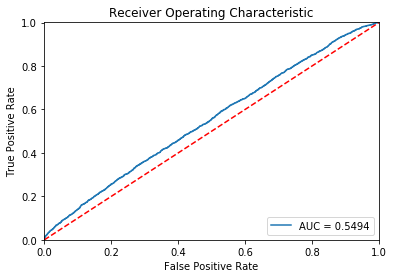

time: 1.04 s


In [55]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [81]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
time: 62 ms


In [59]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True 
[CV] n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True 
[CV] n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True 
[CV] n_estimators=1000, min_samples_split=10, max_depth=20, bootstrap=True 
[CV] n_estimators=1000, min_samples_split=10, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True, total= 1.3min
[CV] n_estimators=1000, min_samples_split=10, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True, total= 1.3min
[CV] n_estimators=1800, min_samples_split=5, max_depth=70, bootstrap=Tr

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 22.3min


[CV]  n_estimators=200, min_samples_split=2, max_depth=20, bootstrap=False, total= 1.6min
[CV] n_estimators=1800, min_samples_split=10, max_depth=30, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, max_depth=100, bootstrap=True, total= 4.5min
[CV] n_estimators=1800, min_samples_split=10, max_depth=30, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=10, max_depth=50, bootstrap=True, total= 8.3min
[CV] n_estimators=1800, min_samples_split=10, max_depth=30, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=10, max_depth=50, bootstrap=True, total= 8.6min
[CV] n_estimators=2000, min_samples_split=2, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, max_depth=50, bootstrap=True, total= 9.0min
[CV] n_estimators=2000, min_samples_split=2, max_depth=20, bootstrap=True 


KeyboardInterrupt: 

time: 31min 40s


In [82]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True 
[CV] n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True 
[CV] n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True 
[CV] n_estimators=1000, min_samples_split=10, max_depth=20, bootstrap=True 
[CV] n_estimators=1000, min_samples_split=10, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, max_depth=100, bootstrap=True, total=   5.5s
[CV] n_estimators=1000, min_samples_split=10, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, max_depth=None, bootstrap=True, total=   5.6s
[CV] n_estimators=1800, min_samples_split=5, max_depth=70, bootstrap=Tr

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min


[CV]  n_estimators=200, min_samples_split=2, max_depth=20, bootstrap=False, total=  11.0s
[CV] n_estimators=1800, min_samples_split=10, max_depth=30, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=10, max_depth=50, bootstrap=True, total=  42.1s
[CV] n_estimators=1800, min_samples_split=10, max_depth=30, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, max_depth=100, bootstrap=True, total=  21.0s
[CV] n_estimators=1800, min_samples_split=10, max_depth=30, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=10, max_depth=50, bootstrap=True, total=  40.6s
[CV] n_estimators=2000, min_samples_split=2, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, max_depth=50, bootstrap=True, total=  40.6s
[CV] n_estimators=2000, min_samples_split=2, max_depth=20, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, max_depth=None, bootstrap=False, total= 1.2min
[CV] n_estimators=2000, min_samples_split=2, max_depth=20, bootstrap=Tru

[CV] n_estimators=200, min_samples_split=2, max_depth=80, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, max_depth=80, bootstrap=True, total=   6.5s
[CV] n_estimators=200, min_samples_split=2, max_depth=80, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, max_depth=80, bootstrap=True, total=   6.6s
[CV] n_estimators=200, min_samples_split=2, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, max_depth=80, bootstrap=True, total=   8.1s
[CV] n_estimators=200, min_samples_split=2, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, max_depth=50, bootstrap=True, total=   8.2s
[CV] n_estimators=200, min_samples_split=2, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=5, max_depth=90, bootstrap=True, total=  32.6s
[CV] n_estimators=800, min_samples_split=5, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, max_depth=50, bootstrap=True, total=   5.5s
[CV] n_estimators=800

[CV]  n_estimators=1200, min_samples_split=5, max_depth=50, bootstrap=True, total=  37.0s
[CV] n_estimators=1400, min_samples_split=10, max_depth=20, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, max_depth=70, bootstrap=False, total= 1.5min
[CV] n_estimators=1400, min_samples_split=10, max_depth=20, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, max_depth=None, bootstrap=False, total=  24.8s
[CV] n_estimators=1400, min_samples_split=10, max_depth=20, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, max_depth=20, bootstrap=True, total=  54.4s
[CV] n_estimators=600, min_samples_split=5, max_depth=30, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, max_depth=20, bootstrap=True, total=  56.8s
[CV] n_estimators=600, min_samples_split=5, max_depth=30, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, max_depth=20, bootstrap=True, total=  53.8s
[CV] n_estimators=600, min_samples_split=5, max_depth=30, bootstrap=True 
[C

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.1min


[CV]  n_estimators=1600, min_samples_split=5, max_depth=30, bootstrap=True, total=  47.6s
[CV] n_estimators=600, min_samples_split=5, max_depth=110, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, max_depth=80, bootstrap=False, total= 1.1min
[CV] n_estimators=600, min_samples_split=5, max_depth=110, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, max_depth=80, bootstrap=False, total= 1.1min
[CV] n_estimators=1600, min_samples_split=5, max_depth=30, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, max_depth=30, bootstrap=True, total=  45.7s
[CV] n_estimators=1600, min_samples_split=5, max_depth=30, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, max_depth=80, bootstrap=False, total= 1.1min
[CV] n_estimators=1600, min_samples_split=5, max_depth=30, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, max_depth=30, bootstrap=True, total=  46.9s
[CV] n_estimators=400, min_samples_split=10, max_depth=80, bootstrap=False

[CV] n_estimators=1200, min_samples_split=2, max_depth=60, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, max_depth=40, bootstrap=True, total=  42.2s
[CV] n_estimators=1600, min_samples_split=5, max_depth=60, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, max_depth=100, bootstrap=False, total=  39.0s
[CV] n_estimators=1600, min_samples_split=5, max_depth=60, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, max_depth=100, bootstrap=False, total=  38.2s
[CV] n_estimators=1600, min_samples_split=5, max_depth=60, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=2, max_depth=40, bootstrap=True, total=  42.3s
[CV] n_estimators=1400, min_samples_split=10, max_depth=80, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, max_depth=100, bootstrap=False, total=  38.9s
[CV] n_estimators=1400, min_samples_split=10, max_depth=80, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, max_depth=60, bootstrap=True, total=  

[CV] n_estimators=400, min_samples_split=2, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, max_depth=70, bootstrap=True, total=  19.3s
[CV] n_estimators=400, min_samples_split=2, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, max_depth=70, bootstrap=True, total=  19.0s
[CV] n_estimators=400, min_samples_split=2, max_depth=20, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=2, max_depth=110, bootstrap=True, total=  45.3s
[CV] n_estimators=800, min_samples_split=10, max_depth=50, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, max_depth=20, bootstrap=True, total=  12.1s
[CV] n_estimators=800, min_samples_split=10, max_depth=50, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, max_depth=20, bootstrap=True, total=  11.6s
[CV] n_estimators=800, min_samples_split=10, max_depth=50, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, max_depth=20, bootstrap=True, total=  11.6s
[CV] n_estimat

[CV]  n_estimators=1800, min_samples_split=2, max_depth=70, bootstrap=False, total= 1.2min
[CV]  n_estimators=1800, min_samples_split=2, max_depth=70, bootstrap=False, total= 1.2min
[CV]  n_estimators=2000, min_samples_split=5, max_depth=40, bootstrap=True, total=  44.1s
[CV]  n_estimators=1800, min_samples_split=2, max_depth=70, bootstrap=False, total= 1.2min


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

time: 24min 26s


In [83]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_split': 2,
 'n_estimators': 600}

time: 7.96 ms


In [115]:
for i in range(min_estimators, max_estimators + 1):
    rf.set_params(n_estimators=i)
    rf.fit(X, y)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate[label].append((i, oob_error))

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr

KeyboardInterrupt: 

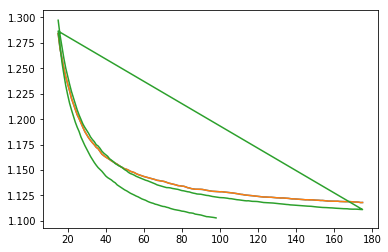

In [116]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

In [146]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', np.mean(errors))

Mean Absolute Error: 0.13699618769215194


In [147]:
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: id                   Importance: 0.42
Variable: num_characters       Importance: 0.2
Variable: bad_words            Importance: 0.13
Variable: asian                Importance: 0.13
Variable: num_capitals         Importance: 0.12
Variable: num_asterisks        Importance: 0.0


In [142]:
feature_list

['id', 'num_asterisks', 'num_characters', 'num_capitals', 'bad_words', 'asian']

In [75]:
n_estimators = 1000
forest = RandomForestRegressor(warm_start=True, oob_score=True)

for i in range(1, n_estimators + 1):
    forest.set_params(n_estimators=i)
    forest.fit(X, y)
    print (i, forest.oob_score_)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 -0.5452094562289558


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


2 -0.6691334235155151


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 -0.6914265003370708


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


4 -0.6656202017941917


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 -0.6305267106178802


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


6 -0.5876519023473774


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


7 -0.5383276397394707


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


8 -0.4920137781394691


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


9 -0.45188446732846876


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 -0.4150948728729513


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


11 -0.38491595540947654


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


12 -0.3572769380368801


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


13 -0.3356542572719976


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


14 -0.3163889208624109


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


15 -0.2992618701187697


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


16 -0.2849205436972384


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


17 -0.2722519947720312


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


18 -0.26103379877387467


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


19 -0.2506478278048756


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 -0.2416045171952541


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


21 -0.23324789581520555


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


22 -0.22508893550221787


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


23 -0.21871958674294723


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


24 -0.21293130734301724


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


25 -0.20826913571963557
26 -0.20343819628122706
27 -0.19896569207056025
28 -0.19482758854961024
29 -0.1907918119270431
30 -0.18806611162856623
31 -0.18494277315203478
32 -0.18300102331230894
33 -0.18012289074028565
34 -0.17791659274525107
35 -0.175319142561009
36 -0.17329508376361225
37 -0.17096790003228013
38 -0.16991599640162214
39 -0.1675362867928749
40 -0.1660916499210403
41 -0.1638612629879761
42 -0.16161682451531068
43 -0.15988401018584564
44 -0.15762848537354346
45 -0.15608994548197996
46 -0.15451468917660915
47 -0.15332922325258092
48 -0.15224278103306332
49 -0.15133440393598874
50 -0.1502236720236605
51 -0.14896890480924352
52 -0.14801680909779602
53 -0.14661301230102985
54 -0.14566131970042062
55 -0.1448967930082259
56 -0.14409554794750323
57 -0.14321897954599816
58 -0.14244786162489942
59 -0.14135878449405714
60 -0.1403055370073032
61 -0.13932694451153393
62 -0.1386406722644966
63 -0.13765254411647954
64 -0.13676732394665736
65 -0.1360521070934031
66 -0.1351349155163255
67 -

KeyboardInterrupt: 

In [76]:
import matplotlib.pyplot as plt
from collections import OrderedDict
RANDOM_STATE = 123
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr

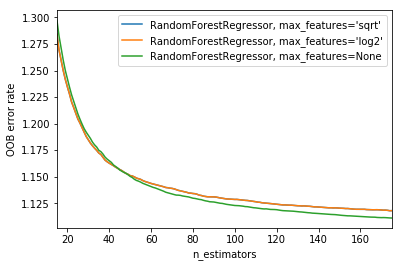

In [77]:
import matplotlib.pyplot as plt
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>